In [1]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [4]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [5]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)
train_subjects.value_counts().to_frame()

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)


In [6]:
generator = FullBatchNodeGenerator(G, method="gcn")
train_gen = generator.flow(train_subjects.index, train_targets)


Using GCN (local pooling) filters...


In [7]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)
x_inp, x_out = gcn.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"])

In [8]:
val_gen = generator.flow(val_subjects.index, val_targets)
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [11]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  
    callbacks=[es_callback])

Epoch 1/200
1/1 - 0s - loss: 1.9517 - acc: 0.1571 - val_loss: 1.9317 - val_acc: 0.1920
Epoch 2/200
1/1 - 0s - loss: 1.9249 - acc: 0.2071 - val_loss: 1.9126 - val_acc: 0.3160
Epoch 3/200
1/1 - 0s - loss: 1.8978 - acc: 0.2643 - val_loss: 1.8866 - val_acc: 0.3660
Epoch 4/200
1/1 - 0s - loss: 1.8479 - acc: 0.3643 - val_loss: 1.8496 - val_acc: 0.3900
Epoch 5/200
1/1 - 0s - loss: 1.8003 - acc: 0.4214 - val_loss: 1.8010 - val_acc: 0.4040
Epoch 6/200
1/1 - 0s - loss: 1.7263 - acc: 0.4286 - val_loss: 1.7430 - val_acc: 0.4240
Epoch 7/200
1/1 - 0s - loss: 1.6458 - acc: 0.4357 - val_loss: 1.6798 - val_acc: 0.4280
Epoch 8/200
1/1 - 0s - loss: 1.5535 - acc: 0.4714 - val_loss: 1.6118 - val_acc: 0.4360
Epoch 9/200
1/1 - 0s - loss: 1.4443 - acc: 0.4714 - val_loss: 1.5433 - val_acc: 0.4380
Epoch 10/200
1/1 - 0s - loss: 1.3761 - acc: 0.4786 - val_loss: 1.4816 - val_acc: 0.4320
Epoch 11/200
1/1 - 0s - loss: 1.2996 - acc: 0.4500 - val_loss: 1.4287 - val_acc: 0.4340
Epoch 12/200
1/1 - 0s - loss: 1.2642 - ac

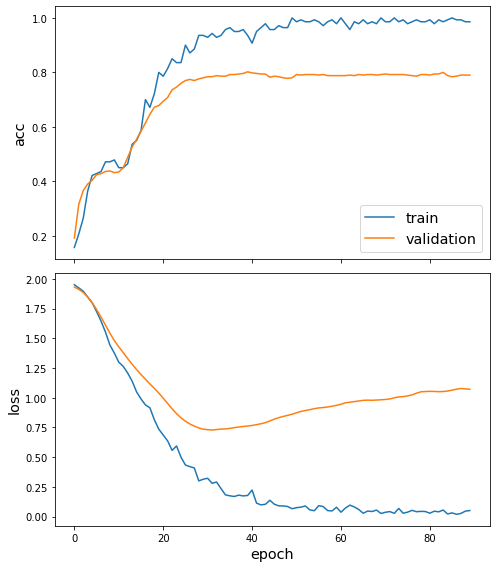

In [12]:
sg.utils.plot_history(history)


In [13]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 1ms/step - loss: 0.7951 - acc: 0.7911

Test Set Metrics:
	loss: 0.7951
	acc: 0.7911


In [14]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())


In [15]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Genetic_Algorithms,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


In [16]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA
X = emb.squeeze(0)